## Hur påverkar solceller priset på en bostad?
Vi undersöker vilken prispåverkan solceller har på ett hus genom att se hur mycket felet i Boolis statistiska värdering skiljer sig mellan hus med solceller och hus utan solceller.

Våra datakällor är Boolis databas med information om bostäder, värderingar och tillhörande annonstexter. 

Vi börjar med att läsa in datan som består av alla försäljningar med tillhörande statistiska värderingar i Sverige mellan 2016-06-01 och 2019-06-01.

In [1]:
import pandas as pd
import numpy as np
estimations = pd.read_csv('/Users/madsen/Desktop/Varderingsdata/knn_all_ot_77104_20160601-20190601.csv')
estimations = estimations[estimations['objectType'].isin(('Villa', 'Radhus', 'Parhus', 'Kedjehus'))]
display("Antal försäljningar: {}".format(estimations['booliId'].count()))


'Antal försäljningar: 247672'

Sedan läser vi in alla försäljningar där vi har tillgång till försäljningsannonsens objektsbeskrivning  

In [2]:
descriptions = pd.read_csv('/Users/madsen/Desktop/HACK/Solceller/descriptions.csv')
display("Antal objektsbeskrivningar: {}".format(descriptions['booliId'].count()))

'Antal objektsbeskrivningar: 97575'

Som vi kan se så har vi inte tillgång till alla objektsbeskrivningar vilket gör att vi förlorar ungefär $\frac{3}{5}$ av datan.

För att ta reda på om de sålda objekten har haft solceller så genomför vi en enkel regex-sökning i objektsbeskrivningar där vi söker efter "solcell" och "solpanel".

In [3]:
import re
descriptions['cell_panel'] = descriptions.description.str.findall(r'solcell|solpanel', flags=re.IGNORECASE).apply(len) > 0
matched = descriptions.cell_panel.value_counts()
display("Antal objektsbeskrivningar utan nyckelord (solcell/solpanel): {}".format(matched[0]))
display("Antal objektsbeskrivningar med nyckelord (solcell/solpanel): {}".format(matched[1]))
display("Andel av objektsbeskrivningar med nyckelord (solcell/solpanel): {}%".format(matched[1] / matched[0] * 100))


'Antal objektsbeskrivningar utan nyckelord (solcell/solpanel): 97341'

'Antal objektsbeskrivningar med nyckelord (solcell/solpanel): 234'

'Andel av objektsbeskrivningar med nyckelord (solcell/solpanel): 0.24039202391592443%'

Vid en enklare visuell inspektion upptäcks endel tvivelaktigheter i förekomsten av nyckelordet solpanel.
Det visar sig att solpanel i stor utsträckning används för att benämna solfångare för uppvärmning av vatten. Ofta även i samband med förekomsten av bergvärme. Vid genomgången upptäcktes även fall då det var tydligt att solpanelen syftade till en solcellsanläggning. Exempel på beskrivande mening var "Solpaneler på tak för egenproducerad el" etc. 
Vi beslutar oss för att ta bort solpanel som nyckelord i regex-filtreringen men behåller ändå de 8 observationer där solpanelen syftade till en solcellsanläggning. 

In [4]:
import re
descriptions['solceller'] = descriptions.description.str.findall(r'solcell', flags=re.IGNORECASE).apply(len) > 0

descriptions.at[descriptions.booliId == 1503326, 'solceller'] = True
descriptions.at[descriptions.booliId == 1798044, 'solceller'] = True
descriptions.at[descriptions.booliId == 3157509, 'solceller'] = True
descriptions.at[descriptions.booliId == 3217586, 'solceller'] = True
descriptions.at[descriptions.booliId == 3316352, 'solceller'] = True
descriptions.at[descriptions.booliId == 3323391, 'solceller'] = True
descriptions.at[descriptions.booliId == 3363937, 'solceller'] = True
descriptions.at[descriptions.booliId == 3582106, 'solceller'] = True

#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_rows', None)
#display(descriptions[descriptions.solceller == True])


Eftersom underlaget är relativt litet beslutar vi oss för att göra en manuell genomgång av alla nyckelordsmatchade annonser. Även ordet solcell är i många fall missförstått och används för att beskriva en solfångare. Vi tar bort alla annonser där det tydligt framgår att det är ett syftningsfel. För varje borttagen annons finns ett citat som styrker detta.  

In [5]:
descriptions.at[descriptions.booliId == 666366, 'solceller'] = False # "Bergvärme Eviheat -06 med kopplingar för solceller."
descriptions.at[descriptions.booliId == 800854, 'solceller'] = False # "Poolen värms upp med solceller"
descriptions.at[descriptions.booliId == 1045951, 'solceller'] = False # "Vattenburen uppvärmning - briketter, solceller och luftvärmepump"
descriptions.at[descriptions.booliId == 1166141, 'solceller'] = False # "samt solceller på taket för poolen"
descriptions.at[descriptions.booliId == 1205770, 'solceller'] = False # "solceller för uppvärmning av poolen"
descriptions.at[descriptions.booliId == 1902299, 'solceller'] = False # "Kamin samt solceller. Ingen el finns."
descriptions.at[descriptions.booliId == 2149835, 'solceller'] = False # "Belysning drivs med solceller."
descriptions.at[descriptions.booliId == 2397467, 'solceller'] = False # "uppvärmd pool via solceller."

descriptions.at[descriptions.booliId == 2407445, 'solceller'] = False # "Värmeanläggningen kan kompletteras med ett solcellspaket"
descriptions.at[descriptions.booliId == 3025817, 'solceller'] = False # "Solceller på tak för uppvärmning av vatten"
descriptions.at[descriptions.booliId == 3159962, 'solceller'] = False # "Poolen värms upp av solceller"
descriptions.at[descriptions.booliId == 3185378, 'solceller'] = False # "solcellspanel för belysning och mobilladdning."
descriptions.at[descriptions.booliId == 3190055, 'solceller'] = False # "utedusch drivna på solceller."
descriptions.at[descriptions.booliId == 3191495, 'solceller'] = False # "uppvärmning med vattenburengolvvärme och radiatorer allt via jordvärmepump och solceller"
descriptions.at[descriptions.booliId == 3225626, 'solceller'] = False # "uppvärmning med solceller,"
descriptions.at[descriptions.booliId == 3249590, 'solceller'] = False # "solceller för att exempelvis ladda mobiler"

descriptions.at[descriptions.booliId == 3268614, 'solceller'] = False # "ABB som storsatsar med solceller "
descriptions.at[descriptions.booliId == 3369155, 'solceller'] = False # "Solcellsel för belysning"
descriptions.at[descriptions.booliId == 3378223, 'solceller'] = False # "Solcellspaneler för uppvärmning "
descriptions.at[descriptions.booliId == 3414821, 'solceller'] = False # "solpotential för solceller"
descriptions.at[descriptions.booliId == 3433052, 'solceller'] = False # "solcellsuppvärmd pool"
descriptions.at[descriptions.booliId == 3434746, 'solceller'] = False # "Solceller finns men är ej installerade och dessa ingår vid husköpet."
descriptions.at[descriptions.booliId == 3435931, 'solceller'] = False # "12V el med solceller och batterier"
descriptions.at[descriptions.booliId == 3452162, 'solceller'] = False # "värms upp med dels solceller"

descriptions.at[descriptions.booliId == 3463096, 'solceller'] = False # "Garagetak lämplig för solceller. "
descriptions.at[descriptions.booliId == 3529323, 'solceller'] = False # "solceller för uppvärmning"
descriptions.at[descriptions.booliId == 3561484, 'solceller'] = False # "uppvärmningsmöjligheter såsom luftvärmepump, solceller och kaminv"
descriptions.at[descriptions.booliId == 3582997, 'solceller'] = False # "lägenheten"
descriptions.at[descriptions.booliId == 3612605, 'solceller'] = False # "bostadsrättsparhus"
descriptions.at[descriptions.booliId == 3613601, 'solceller'] = False # "rätta förutsättningarna för installation av solceller"
descriptions.at[descriptions.booliId == 3645361, 'solceller'] = False # "föreningen investerat i solceller"


In [6]:
matched_sol = descriptions.solceller.value_counts()
display("Antal objektsbeskrivningar utan nyckelord (solcell): {}".format(matched_sol[0]))
display("Antal objektsbeskrivningar med nyckelord (solcell): {}".format(matched_sol[1]))
display("Andel av objektsbeskrivningar med nyckelord (solcell): {}%".format(matched_sol[1] / matched_sol[0] * 100))

'Antal objektsbeskrivningar utan nyckelord (solcell): 97471'

'Antal objektsbeskrivningar med nyckelord (solcell): 104'

'Andel av objektsbeskrivningar med nyckelord (solcell): 0.1066984026017995%'

Efter den manuella inspektionen av annonsbeskrivningarna återstår 104 observationer vilket motsvarar ca 0.11 % av alla annonsbeskrivningar. 
Enligt Energimyndigheten https://www.energimyndigheten.se/nyhetsarkiv/2019/ett-ar-senare---10-000-fler-natanslutna-solcellsanlaggningar/ så fanns det ungefär 25 500 installerade solcellsanläggningar i Sverige vid slutet av 2018, varav 84 % var mindre anläggningar lämpliga för villatak etc. Ett rimligt antagande är att det i genomsnitt, under den aktuella perioden för denna analys, fanns ca 20 000 solcellsanläggningar. Enligt Boverket https://www.boverket.se/sv/samhallsplanering/bostadsmarknad/bostadsbestandet/ fanns det ungefär 2 miljoner småhus i Sverige vid slutet av 2018. Sammantaget innebär det att ca 1 % av alla småhus har en installerad solcellsanläggning.  Vilket då innebär att vi som minst har, via regex-filtreringen, lyckats urskilja ca $\frac{0.11}{1} = 11$ % av alla försäljningar. Det finns alltså möjlighet att förbättra analysen om vi lyckas få en bättre täckningsgrad på datan.    

Vi genomför en regex-filtrering på annonser innehållande ordet "Bergvärme" eftersom bergvärme i många fall även finns installerat i de hus som har solceller. På så sätt kan vi skilja dessa hus åt och skapa grupper för hus med solceller respektive hus med solceller och bergvärme.

In [7]:
descriptions['bergvarme'] = descriptions.description.str.findall(r'bergvärme', flags=re.IGNORECASE).apply(len) > 0
matched_berg = descriptions.bergvarme.value_counts()
display("Antal objektsbeskrivningar med nyckelord (Bergvärme): {}".format(matched_berg[1]))

'Antal objektsbeskrivningar med nyckelord (Bergvärme): 7006'

Vi fortsätter analysen genom att göra en grundläggande outlierfiltrering på försäljningspris och värderingsfel.

In [8]:
# Remove outliers based on soldPrice and estimation error
filtered = estimations
quantiles = filtered['soldPrice'].quantile([0.01, 0.99])
filtered = filtered[(filtered['soldPrice'] >= quantiles[0.01]) &
                    (filtered['soldPrice'] <= quantiles[0.99])]
quantiles = filtered['error_percent'].quantile([0.05, 0.95])
filtered = filtered[(filtered['error_percent'] >= quantiles[0.05]) &
                    (filtered['error_percent'] <= quantiles[0.95])]


Nu matchar vi de regex-filtrerade annonsbeskrivningarna med de outlierfiltrerade slutpriserna.  

In [9]:
filtered = pd.merge(filtered, descriptions, on='booliId')

matched_filtered = filtered.solceller.value_counts()
estimations['solcell'] = estimations.booliId.isin(descriptions[descriptions.solceller == True].booliId).astype(np.int8)
matched_non_filtered = estimations.solcell.value_counts()
filtered['sol_berg'] = filtered.booliId.isin(filtered[(filtered.solceller == True) & (filtered.bergvarme == True)].booliId).astype(np.int8)

matched_sol_berg = filtered.sol_berg.value_counts()
filtered['sol_not_berg'] = filtered.booliId.isin(descriptions[(descriptions.bergvarme == False) & (descriptions.solceller == True)].booliId).astype(np.int8)
display("Antal objektsbeskrivningar med nyckelord (solcell) innan filtrering: {}".format(matched_non_filtered[1]))
display("Antal objektsbeskrivningar med nyckelord (solcell) efter filtrering: {}".format(matched_filtered[1]))
display("Antal objektsbeskrivningar med nyckelord (solcell och bergvärme) efter filtrering: {}".format(matched_sol_berg[1]))
display("Andel objektsbeskrivningar med nyckelord (solcell och bergvärme): {} %".format(matched_sol_berg[1] / matched_filtered[1] * 100))


'Antal objektsbeskrivningar med nyckelord (solcell) innan filtrering: 40'

'Antal objektsbeskrivningar med nyckelord (solcell) efter filtrering: 37'

'Antal objektsbeskrivningar med nyckelord (solcell och bergvärme) efter filtrering: 5'

'Andel objektsbeskrivningar med nyckelord (solcell och bergvärme): 13.513513513513514 %'

Det ger oss 37 småhusförsäljningar i Sverige mellan 2016-06-01 och 2019-06-01 som kan antas ha installerade solcellsanläggningar. Som vi kan se så är det ungefär $\frac{37}{135} \approx \frac{1}{4}$ av alla annonstexter som matchas med ett slutpris, vilket till stor del beror på att annonsbeskrivningarna tillhörde försäljningar gjorda innan 2016-06-01. Vi kan också se att i 14 % av annonserna som innehöll solceller också innehåller bergvärme.  

## Analys

### Varierar felfördelningarna mellan de som har solceller och de som inte har?

'Har solceller = False'

Median error: -1.1620689655172416 %
count    27627.000000
mean         0.007641
std          0.203850
min         -0.407329
25%         -0.122618
50%         -0.011621
75%          0.108990
max          0.818769
Name: error_percent, dtype: float64


'Har solceller = True'

Median error: -8.349165217391304 %
count    37.000000
mean     -0.047035
std       0.167430
min      -0.321181
25%      -0.131989
50%      -0.083492
75%       0.025670
max       0.612122
Name: error_percent, dtype: float64


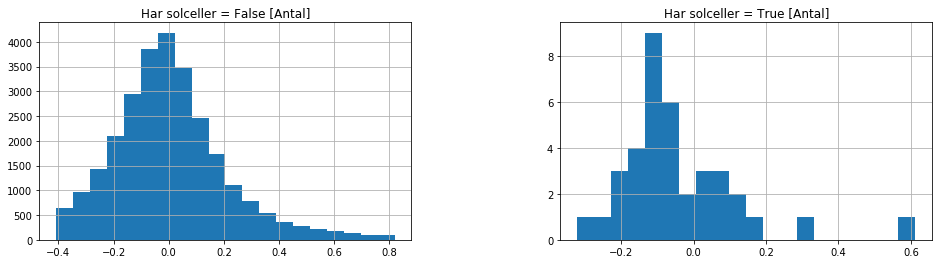

In [10]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(16,4))
f.subplots_adjust(hspace=0.4, wspace=0.4)

for i, label in enumerate(filtered['solceller'].unique()):
    df = filtered[filtered['solceller'] == label]
    ax = f.add_subplot(1, 2, i+1)
    ax.set_title("Har solceller = {} [Antal]".format(label))
    df['error_percent'].hist(bins=20)
    display("Har solceller = {}".format(label))
    print("Median error: {} %".format(df['error_percent'].median() * 100))
    print(df['error_percent'].describe())

Eftersom vi tittar på samtliga småhus i hela landet får vi, trots vår outlierfiltrering, ganska långa svansar med stora värderingsfel. Upp mot 80 % övervärdering eller 40 % undervärdering i värsta fallen. Fördelningen för värderingsfelet gällande hus utan solceller är log-normal och centrerad kring 0 % med ett medelvärde på 0.8%, och en standardavvikelsen på ca 20 %, vilket innebär att 2/3 av alla värderingar hamnar inom 23 % från rätt försäljningspris. Vi kan antyda att fördelningen av värderingsfelen för hus med solceller är log-normal med en förskjuten centrering runt -0.1. Den har ett medelvärde på - 4.7 % och en standardavvikelsen på ca 17 %. 

Median error: -8.349165217391304 %
count    5.000000
mean    -0.096823
std      0.067289
min     -0.163929
25%     -0.161533
50%     -0.083492
75%     -0.070923
max     -0.004238
Name: error_percent, dtype: float64


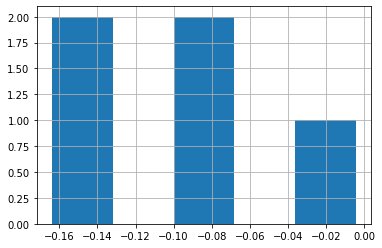

In [11]:
df = filtered[filtered['sol_berg'] == True]
print("Median error: {} %".format(df['error_percent'].median() * 100))
df['error_percent'].hist(bins=5)
print(df['error_percent'].describe())

Om vi tittar på de annonser som innehöll både solcell och bergvärme så får vi ett medelvärde på -9.7 %.

Median error: -5.756755905511811 %
count    1819.000000
mean       -0.040044
std         0.194613
min        -0.406733
25%        -0.178757
50%        -0.057568
75%         0.069393
max         0.802347
Name: error_percent, dtype: float64


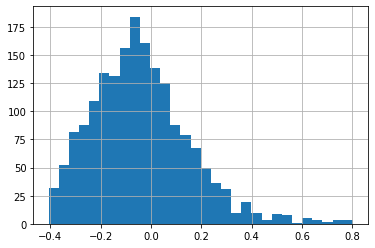

In [12]:
df = filtered[filtered['bergvarme'] == True]
print("Median error: {} %".format(df['error_percent'].median() * 100))
df['error_percent'].hist(bins=30)
print(df['error_percent'].describe())

När vi tittar på fördelningen för värderingsfelet för de annonstexter som innehöll bergvärme så ser vi ser vi ett medelvärde på -4 %.

### Är det vanligare med solceller för vissa prisklasser eller storleksklasser?

In [13]:
pearson_corr = filtered[[
    'solceller',
    'soldPrice',
    'estimatedPrice',
    'plotArea',
    'livingArea',
    'additionalArea',
    'rooms',
    'constructionYear',
    'bergvarme',
]].corr(method='pearson')

display(pearson_corr['solceller'])

solceller           1.000000
soldPrice           0.014430
estimatedPrice      0.010244
plotArea            0.014078
livingArea          0.009250
additionalArea      0.002497
rooms               0.011296
constructionYear    0.010394
bergvarme           0.010244
Name: solceller, dtype: float64

Vi kan tydligt se att de flesta attribut har en låg och jämt fördelad korrelation till förekomsten av solceller.

## Resultat

I tabellerna som följer så innebär negativa siffror att vi undervärderar. Första tabellen anger värderingsfelet för hus med solceller, om vi inte tar hänsyn till förekomsten av bergvärme. 

In [14]:
filtered.groupby('solceller').agg(
    Antal=('error', len),
    Medianfel_SEK=('error', np.median),
    Medelfel_SEK=('error', np.mean),
    Medianfel_procent=('error_percent', np.median),
    Medelfel_procent=('error_percent', np.mean)
)

,Antal,Medianfel_SEK,Medelfel_SEK,Medianfel_procent,Medelfel_procent
solceller,,,,,
False,27627.0,-30066.0,-57149.866906,-0.011621,0.007641
True,37.0,-355315.0,-325141.621622,-0.083492,-0.047035


Nedan följer en tabell som visar värderingsfelet för annonser innehållande bergvärme.

In [15]:
filtered.groupby('bergvarme').agg(
    Antal=('error', len),
    Medianfel_SEK=('error', np.median),
    Medelfel_SEK=('error', np.mean),
    Medianfel_procent=('error_percent', np.median),
    Medelfel_procent=('error_percent', np.mean)
)

,Antal,Medianfel_SEK,Medelfel_SEK,Medianfel_procent,Medelfel_procent
bergvarme,,,,,
False,25845.0,-23898.0,-49610.263842,-0.008880,0.010919
True,1819.0,-145405.0,-169726.412314,-0.057568,-0.040044


Nedan följer en tabell som visar värderingsfelet för annonser innehållande solceller och bergvärme.

In [16]:
filtered.groupby('sol_berg').agg(
    Antal=('error', len),
    Medianfel_SEK=('error', np.median),
    Medelfel_SEK=('error', np.mean),
    Medianfel_procent=('error_percent', np.median),
    Medelfel_procent=('error_percent', np.mean)
)

,Antal,Medianfel_SEK,Medelfel_SEK,Medianfel_procent,Medelfel_procent
sol_berg,,,,,
0,27659.0,-30259.0,-57425.334936,-0.011681,0.007587
1,5.0,-520944.0,-516454.800000,-0.083492,-0.096823


Nedan följer en tabell som visar värderingsfelet för annonser innehållande solceller men inte bergvärme.

In [17]:
filtered.groupby('sol_not_berg').agg(
    Antal=('error', len),
    Medianfel_SEK=('error', np.median),
    Medelfel_SEK=('error', np.mean),
    Medianfel_procent=('error_percent', np.median),
    Medelfel_procent=('error_percent', np.mean)
)

,Antal,Medianfel_SEK,Medelfel_SEK,Medianfel_procent,Medelfel_procent
sol_not_berg,,,,,
0,27632.0,-30101.0,-57232.97796,-0.011626,0.007622
1,32.0,-322425.5,-295248.93750,-0.085456,-0.039256


In [26]:
from scipy.stats import ttest_ind

with_solar = filtered[filtered['solceller'] == True]
without_solar = filtered[filtered['solceller'] == False]
display(ttest_ind(with_solar['error_percent'], without_solar['error_percent']))


Ttest_indResult(statistic=-1.6307664347632786, pvalue=0.10295099694121494)

Ett t-test ger ett p-värde på ca 0.1. Det är inte ett signifikant p-värde och beror förmodligen på obalansen mellan datasetens storlekar. P-värdet borde rimligtvis minska något med ett större underlag av sålda fastigheter med solceller.  

## Slutsats och kommentar

### Slutsats: Solceller är värdehöjande.

En jämförelse av alla försäljningar i landet visar att solceller är värt ca 320 000 SEK. 
Vi kan se att förekomsten av solceller korrelerar med en förhållandevis stor negativ avvikelse från medelfelet för hela populationen. D.v.s. vi värderar hus med solceller för lågt, vilket kan tolkas som att solceller är värdehöjande. Antalet observationer ska tas i beaktande då uttalande kring specifik värdeökning i kronor görs. Man kan dock, ganska betryggande, påstå att solceller är värdehöjande för en fastighet. En möjlig väg att gå för att få tillgång till mer omfattande underlag är att få data förmedlat via regionnätsägarna, exempelvis Vattenfall, då de har information om anslutna solcellsanläggningar inom deras regionnätsområden. Något de idag förmedlar till energimyndigheten och som sedan används för att sammanställa antalet installerade solcellsanläggningar nationellt.  
Vidare så visar en jämförelse av alla försäljningar i landet, då bergvärme funnits i objektsbeskrivningen, att bergvärme är värt ca 150 000 SEK. Det stämmer bra överens med den analys som tidigare gjorts gällande värdet av installerad bergvärme. Den analysen är genomförd med mer omfattande data. Se länk: https://jobb.booli.se/blog/posts/19601-hur-paverkar-bergvarme-vardet-pa-ett-hus
De överensstämmande resultaten, gällande bergvärme, styrker trovärdigheten i denna analys och visar att tillfredställande underlag kan urskiljas med hjälp av en regex-filtrering på annonsbeskrivningar. 

Vidare visar denna analys att objektsbeskrivningar innehållande både solceller och bergvärme har ett värde på 520 000. Detta motsvarar en kombination av det individuella värdet för solceller och bergvärme, vilket är rimligt.  Denna summa är baserad på endast 5 observationer vilket bör tas i beaktande då uttalanden om ett specifikt värde görs.  